In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.sparse import lil_matrix
import pickle

%matplotlib inline

with open('train_single_relation.txt', 'w') as fw:
    with open('train', 'r') as f:
        for line in f.readlines():
            start, relations, end = line.split('\t')
            if ',' not in relations:
                fw.write(line)

In [2]:
datafile = '../data/freebase/train_single_relation.txt'

entities = set()
relations = set()
with open(datafile, 'r') as f:
    for line in f.readlines():
        start, relation, end = line.split('\t')
        if start.strip() not in entities:
            entities.add(start.strip())
        if end.strip() not in entities:
            entities.add(end.strip())
        if relation.strip() not in relations:
            relations.add(relation)

In [3]:
n_entities = len(entities)
entities = list(entities)
entity_dic = {entities[k]:k for k in range(len(entities))}

In [4]:
n_relations = len(relations)
relations = list(relations)
relation_dic = {relations[k]:k for k in range(len(relations))}

selected_relations = list() #manually selected list of relations
selected_relations.append(relation_dic['place_of_birth'])
selected_relations.append(relation_dic['place_of_death'])
selected_relations.append(relation_dic['nationality'])
selected_relations.append(relation_dic['location'])

In [5]:
entity_count = np.zeros(n_entities)
T = [lil_matrix((n_entities, n_entities), dtype=int) for k in range(n_relations)]
cnt = 0
with open(datafile, 'r') as f:
    for line in f.readlines():
        start, relation, end = line.split('\t')
        e_i = entity_dic[start.strip()]
        e_j = entity_dic[end.strip()]
        r_k = relation_dic[relation.strip()]
        T[r_k][e_i,e_j] = 1
        if r_k in selected_relations:
            if e_i == e_j:
                entity_count[e_i] += 1
            else:
                entity_count[e_i] += 1
                entity_count[e_j] += 1
T = [X.tocsr() for X in T]
entities = np.array(entities)
relations = np.array(relations)

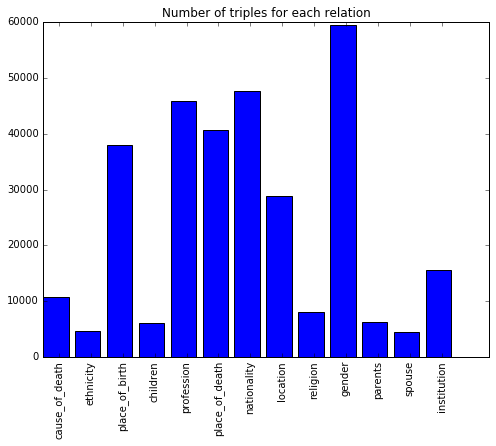

In [6]:
plt.figure(figsize=(8,6))
plt.bar(range(n_relations), [T[k].nnz for k in range(n_relations)])
plt.xticks(np.arange(0.5, n_relations), relations, rotation='vertical')
plt.title('Number of triples for each relation')

In [7]:
print('num entity', n_entities)
print('num triples', np.sum([T[k].nnz for k in range(n_relations)]))
print('sparsity', np.sum([T[k].nnz for k in range(n_relations)])/(n_relations * n_entities**2))

num entity 75043
num triples 316232
sparsity 4.31958562619e-06


## Subset of dataset

In [8]:
n_new_entity = 5000
new_idx = sorted(range(len(entity_count)), key=lambda i: entity_count[i], reverse=True)[:n_new_entity]

In [9]:
newT = np.zeros([len(selected_relations), n_new_entity, n_new_entity])
for idx, k in enumerate(selected_relations):
    newT[idx] = T[k][new_idx, :][:, new_idx].todense()

In [10]:
print('num triple', np.sum([X.sum() for X in newT]))
print('sparsity', np.sum([X.sum() for X in newT]) / (n_new_entity**2 * n_relations))

num triple 9393.0
sparsity 2.89015384615e-05


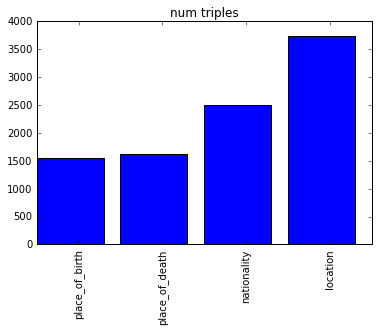

In [11]:
plt.bar(range(len(selected_relations)), [X.sum() for X in newT])
plt.xticks(np.arange(0.5, len(selected_relations)), relations[selected_relations], rotation='vertical')
plt.title('num triples')

In [12]:
pickle.dump([newT, entities[new_idx], relations[selected_relations]], open('../data/freebase/subset.pkl','wb'))